In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split


In [ ]:

# Paths
LEFT_DIR = "/content/drive/MyDrive/EE 417/data-scene-flow/training/image_2_cropped"
RIGHT_DIR = "/content/drive/MyDrive/EE 417/data-scene-flow/training/image_3_cropped"
GT_DIR = "/content/drive/MyDrive/EE 417/data-scene-flow/training/disp_occ_0_cropped"

IMG_HEIGHT, IMG_WIDTH = 231, 1242
BATCH_SIZE = 2
EPOCHS = 10


In [ ]:

def load_image(path):
    img = cv2.imread(path)[..., ::-1]
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LINEAR)
    return img / 255.0

def load_disparity(path):
    disp = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32) / 256.0
    disp = cv2.resize(disp, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    if disp.ndim == 2:
        disp = disp[..., np.newaxis]
    return disp


In [ ]:

all_filenames = sorted(os.listdir(LEFT_DIR))
train_filenames, val_filenames = train_test_split(all_filenames, test_size=0.1, random_state=42)

def data_generator(filenames, augment=False):
    def gen():
        while True:
            for fname in filenames:
                L = load_image(os.path.join(LEFT_DIR, fname))
                R = load_image(os.path.join(RIGHT_DIR, fname))
                G = load_disparity(os.path.join(GT_DIR, fname))
                if augment and np.random.rand() > 0.5:
                    L = np.fliplr(L)
                    R = np.fliplr(R)
                    G = np.fliplr(G)
                yield (L, R), G
    return tf.data.Dataset.from_generator(
        gen,
        output_types=((tf.float32, tf.float32), tf.float32),
        output_shapes=(((IMG_HEIGHT, IMG_WIDTH, 3), (IMG_HEIGHT, IMG_WIDTH, 3)), (IMG_HEIGHT, IMG_WIDTH, 1))
    )

train_ds = data_generator(train_filenames, augment=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = data_generator(val_filenames).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
steps_per_epoch = len(train_filenames) // BATCH_SIZE
val_steps = len(val_filenames) // BATCH_SIZE


Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [ ]:

from tensorflow.keras import layers, models

def feature_extractor():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    return models.Model(inputs, x)

def stereo_matching(left_feat, right_feat):
    x = layers.Concatenate()([left_feat, right_feat])
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.UpSampling2D(size=4, interpolation="bilinear")(x)
    x = layers.Cropping2D(((1, 2), (1, 1)))(x)
    disp = layers.Conv2D(1, 3, padding="same", activation="relu")(x)
    return disp

def build_hitnet():
    left_input = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    right_input = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    feature_net = feature_extractor()
    left_feat = feature_net(left_input)
    right_feat = feature_net(right_input)
    disp = stereo_matching(left_feat, right_feat)
    return models.Model(inputs=[left_input, right_input], outputs=disp)


In [ ]:

def smoothness_loss(disp, image):
    disp_grad_x = tf.abs(disp[:, :, 1:, :] - disp[:, :, :-1, :])
    disp_grad_y = tf.abs(disp[:, 1:, :, :] - disp[:, :-1, :, :])
    image_grad_x = tf.abs(image[:, :, 1:, :] - image[:, :, :-1, :])
    image_grad_y = tf.abs(image[:, 1:, :, :] - image[:, :-1, :, :])
    weights_x = tf.exp(-tf.reduce_mean(image_grad_x, axis=-1, keepdims=True))
    weights_y = tf.exp(-tf.reduce_mean(image_grad_y, axis=-1, keepdims=True))
    return tf.reduce_mean(disp_grad_x * weights_x) + tf.reduce_mean(disp_grad_y * weights_y)

def combined_loss(y_true, y_pred):
    y_true = tf.image.resize_with_crop_or_pad(y_true, tf.shape(y_pred)[1], tf.shape(y_pred)[2])
    mask = tf.cast(y_true > 0, tf.float32)
    diff = tf.abs(y_true - y_pred) * mask
    mae = tf.math.divide_no_nan(tf.reduce_sum(diff), tf.reduce_sum(mask))
    smooth = smoothness_loss(y_pred, y_pred)
    return mae + 0.1 * smooth


In [ ]:

model = build_hitnet()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=combined_loss)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    callbacks=callbacks
)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - loss: 27.4415 - val_loss: 18.5536 - learning_rate: 1.0000e-04
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 272ms/step - loss: 17.0757 - val_loss: 13.3782 - learning_rate: 1.0000e-04
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 454ms/step - loss: 13.5780 - val_loss: 12.2713 - learning_rate: 1.0000e-04
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - loss: 13.1163 - val_loss: 12.1205 - learning_rate: 1.0000e-04
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 275ms/step - loss: 12.4933 - val_loss: 11.7123 - learning_rate: 1.0000e-04
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 271ms/step - loss: 12.0495 - val_loss: 11.4239 - learning_rate: 1.0000e-04
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 266ms/step - loss: 11.8831 - val_loss: 11.1631 - learning_rate: 1.0000e-04
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 269ms/step - loss: 11.7266 - val_loss: 10.9983 - learning_rate: 1.0000e-04
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 269ms/step - loss: 11.54

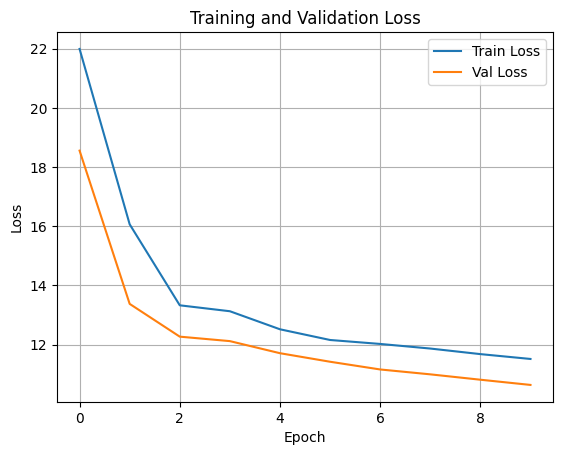

In [ ]:

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


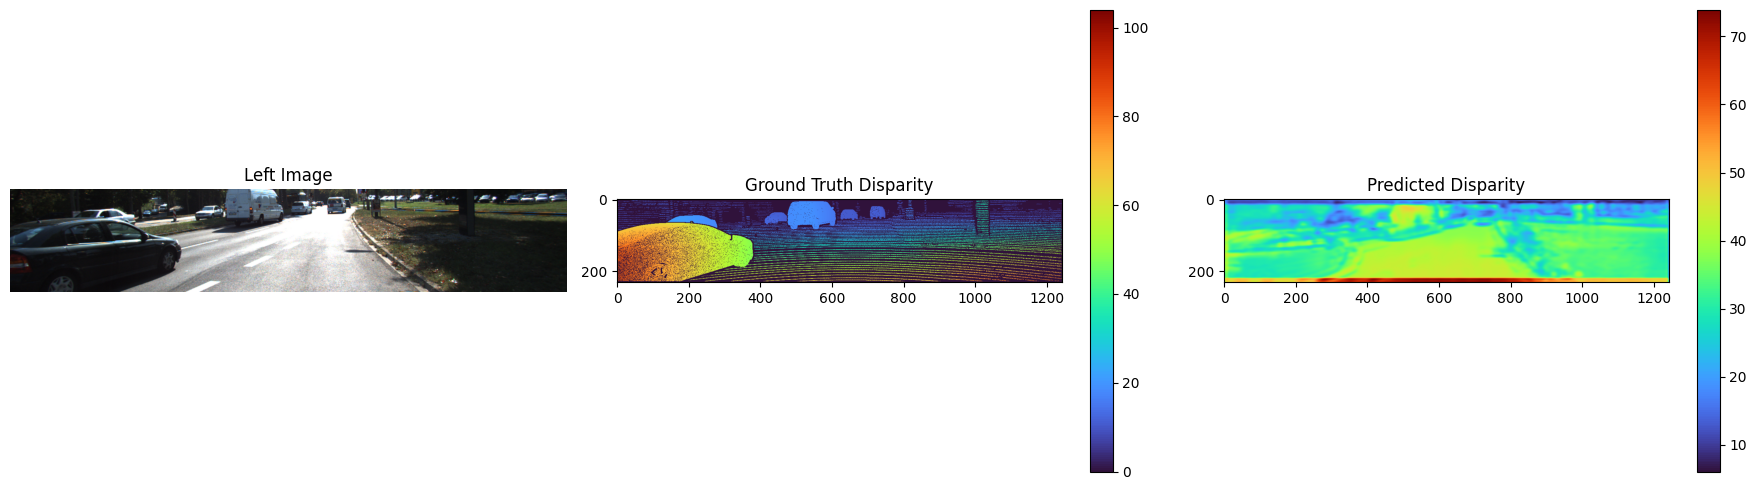

In [ ]:

for (L, R), G in val_ds.take(1):
    pred = model([L, R], training=False)[0].numpy()
    gt = G[0].numpy()
    left_img = L[0].numpy()

    pred_disp = tf.image.resize(pred, (IMG_HEIGHT, IMG_WIDTH)).numpy()[..., 0]
    gt_disp = gt[..., 0]

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(left_img)
    plt.title("Left Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gt_disp, cmap='turbo')
    plt.title("Ground Truth Disparity")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(pred_disp, cmap='turbo')
    plt.title("Predicted Disparity")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


In [ ]:

import time

total_pixels, total_d1_error, total_mae, total_rmse, total_epe = 0, 0, 0, 0, 0
start_time = time.time()

for (L, R), G in val_ds.take(val_steps):
    pred = model([L, R], training=False).numpy()
    gt = G.numpy()

    for i in range(pred.shape[0]):
        pred_disp = tf.image.resize(pred[i], size=(IMG_HEIGHT, IMG_WIDTH), method='bilinear').numpy()[..., 0]
        gt_disp = gt[i, ..., 0]

        valid_mask = gt_disp > 0
        valid_gt = gt_disp[valid_mask]
        valid_pred = pred_disp[valid_mask]

        if valid_gt.size == 0:
            continue

        abs_error = np.abs(valid_pred - valid_gt)
        sq_error = (valid_pred - valid_gt) ** 2

        bad_pixels = ((abs_error > 3) & (abs_error / valid_gt > 0.05)).sum()
        total_d1_error += bad_pixels
        total_pixels += valid_gt.size

        total_mae += np.sum(abs_error)
        total_rmse += np.sum(sq_error)
        total_epe += np.sum(abs_error)

elapsed = time.time() - start_time
mae = total_mae / total_pixels
rmse = np.sqrt(total_rmse / total_pixels)
epe = total_epe / total_pixels
d1_error = total_d1_error / total_pixels * 100

print(f"📏 Disparity computation time: {elapsed:.2f} sec")
print(f"📊 KITTI D1-all error      : {d1_error:.2f}%")
print(f"📊 Mean Absolute Error (MAE): {mae:.4f} px")
print(f"📊 Root Mean Squared Error : {rmse:.4f} px")
print(f"📊 End-Point Error (EPE)   : {epe:.4f} px")


📏 Disparity computation time: 2.34 sec
📊 KITTI D1-all error      : 82.96%
📊 Mean Absolute Error (MAE): 10.8353 px
📊 Root Mean Squared Error : 13.9245 px
📊 End-Point Error (EPE)   : 10.8353 px
